# Predicting Remaining Useful Life
<p style="margin:30px">
    <img style="display:inline; margin-right:50px" width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
    <img style="display:inline" width=15% src="https://upload.wikimedia.org/wikipedia/commons/e/e5/NASA_logo.svg" alt="NASA" />
</p>

The general setup for the problem is a common one: we have a single table of sensor observations over time. Now that collecting information is easier than ever, most industries have already generated *time-series* type problems by the way that they store data. As such, it is crucial to be able to handle data in this form. Thankfully, built-in functionality from [Featuretools](https://www.featuretools.com) handles time varying data well.

We'll demonstrate an end-to-end workflow using a [Turbofan Engine Degradation Simulation Data Set](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) from NASA. This notebook demonstrates a rapid way to predict the Remaining Useful Life (RUL) of an engine using an initial dataframe of time-series data. There are three sections of the notebook:
1. [Understand the Data](#Step-1:-Understanding-the-Data)
2. [Generate features](#Step-2:-DFS-and-Creating-a-Model)
3. [Make predictions with Machine Learning](#Step-3:-Using-the-Model)

*To run the notebooks, you need to download the data yourself. Download and unzip the file from [https://ti.arc.nasa.gov/c/13/](https://ti.arc.nasa.gov/c/6/). Then create a 'data' directory and place the files in the 'data' directory.*


## Highlights
* Quickly make end-to-end workflow using time-series data
* Find interesting automatically generated features

# Step 1: Understanding the Data
Here we load in the train data and give the columns names according to the `description.txt` file.

In [2]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import utils
import os

In [3]:
data_path = 'data/train_FD004.txt'
data = utils.load_data(data_path)

data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


## NASA Run To Failure Dataset
In this dataset we have 249 engines (`engine_no`) which are monitored over time (`time_in_cycles`). Each engine had `operational_settings` and `sensor_measurements` recorded for each cycle. The **Remaining Useful Life** (RUL) is the amount of cycles an engine has left before it needs maintenance.
What makes this dataset special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time.

To train a model that will predict RUL, we can can simulate real predictions on by choosing a random point in the life of the engine and only using the data from before that point. We can create features with that restriction easily by using [cutoff_times](https://docs.featuretools.com/automated_feature_engineering/handling_time.html) in Featuretools. To structure the labeling process, we will use [Compose](https://compose.featurelabs.com) which is an open source project for automatically generating labels with cutoff times.

### Define Labeling Function
To get started, we define the labeling function that will return the RUL given the remaining observations of an engine.

In [4]:
def remaining_useful_life(df):
    return len(df) - 1

### Create Label Maker
With the labeling function, we create the label maker for our prediction problem. To process the RUL for each engine, we set the `target_entity` to the engine number. By default, the `window_size` is set to the total observation size to contain the remaining observations for each engine.

In [5]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

### Search Labels
Let’s imagine we want to make predictions on turbines that are up and running. Turbines in general don’t fail before 120 cycles, so we will only make labels for engines that reach at least 100 cycles. To do this, the `minimum_data` parameter is set to 100. Using Compose, we can easily tweak this parameter as the requirements of our model changes. By setting `num_examples_per_instance` to one, we limit the search to one example per engine.

In [6]:
label_times = lm.search(
    data.sort_values('time'),
    num_examples_per_instance=1,
    minimum_data=100,
    verbose=True,
)

label_times.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|███████████████████████████████████████████████| engine_no: 249/249 


,engine_no,time,remaining_useful_life
0,1,2000-01-01 16:40:00,220
1,2,2000-01-03 22:10:00,198
2,3,2000-01-06 00:00:00,206
3,4,2000-01-08 03:10:00,173
4,5,2000-01-10 00:50:00,92


Let's walk through a row of the `labels_times` dataframe. In the third row, we have engine number 3. At 00:00 on January 6, the remaining useful life of engine number 3 is 206. Having a dataframe in this format tells Featuretools that the feature vector for engine number 3 should only be calculated with data from before that point in time.

To apply Deep Feature Synthesis we need to establish an `EntitySet` structure for our data. The key insight in this step is that we're really interested in our data as collected by `engine`. We can create an `engines` entity by normalizing by the `engine_no` column in the raw data. In the next section, we'll create a feature matrix for the `engines` entity directly rather than the base dataframe of `recordings`.

In [7]:
def make_entityset(data):
    es = ft.EntitySet('Dataset')

    es.entity_from_dataframe(
        dataframe=data,
        entity_id='recordings',
        index='index',
        time_index='time',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='engines',
        index='engine_no',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='cycles',
        index='time_in_cycles',
    )

    return es

In [8]:
es = make_entityset(data)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 28]
    engines [Rows: 249, Columns: 2]
    cycles [Rows: 543, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

## Visualize EntitySet

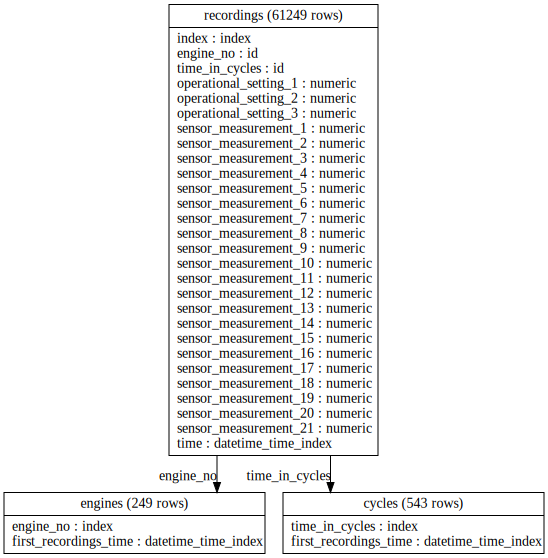

In [9]:
es.plot()

# Step 2: DFS and Creating a Model
With the work from the last section in hand, we can quickly build features using Deep Feature Synthesis (DFS). The function `ft.dfs` takes an `EntitySet` and stacks primitives like `Max`, `Min` and `Last` exhaustively across entities. Feel free to try the next step with a different primitive set to see how the results differ!

We build features only using data up to and including the cutoff time of each label. This is done by setting the `cutoff_time` parameter to the label times we generated previously. Notice that the output of Compose integrates easily with Featuretools.

In [10]:
fm, features = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', 'min'],
    trans_primitives=[],
    cutoff_time=label_times,
    max_depth=3,
    verbose=True,
)

fm.to_csv('simple_fm.csv')

Built 292 features
Elapsed: 01:28 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


## Machine Learning Baselines
Before we use that feature matrix to make predictions, we should check how well guessing does on this dataset. We can use a `train_test_split` from scikit-learn to split our training data once and for all. Then, we'll check the following baselines:
1. Always predict the median value of `y_train`
2. Always predict the RUL as if every engine has the median lifespan in `X_train`

We'll check those predictions by finding the mean of the absolute value of the errors.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [12]:
fm = pd.read_csv('simple_fm.csv', index_col='engine_no')
X = fm.copy().fillna(0)
y = X.pop('remaining_useful_life')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

medianpredict1 = [np.median(y_train) for _ in y_test]
mae = mean_absolute_error(medianpredict1, y_test)
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(mae))

Baseline by median label: Mean Abs Error = 59.98


In [13]:
from_train = es['recordings'].df['engine_no'].isin(y_train.index)
recordings_from_train = es['recordings'].df[from_train]
engines = recordings_from_train.groupby(['engine_no'])
median_life = np.median(engines.apply(lambda df: df.shape[0]))

from_test = es['recordings'].df['engine_no'].isin(y_test.index)
recordings_from_test = es['recordings'].df[from_test]
engines = recordings_from_test.groupby(['engine_no'])
life_in_test = engines.apply(lambda df: df.shape[0]) - y_test

medianpredict2 = median_life - life_in_test
medianpredict2 = medianpredict2.apply(lambda row: max(row, 0))
mae = mean_absolute_error(medianpredict2, y_test)
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(mae))

Baseline by median life: Mean Abs Error = 59.98


# Step 3: Using the Model
Now, we can use our created features to fit a `RandomForestRegressor` to our data and see if we can improve on the previous scores.

In [14]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
scores = mean_absolute_error(preds, y_test)
print('Mean Abs Error: {:.2f}'.format(scores))

high_imp_feats = utils.feature_importances(X, reg, feats=10)

Mean Abs Error: 49.17
1: MIN(recordings.cycles.LAST(recordings.sensor_measurement_11)) [0.068]
2: MAX(recordings.sensor_measurement_4) [0.051]
3: MAX(recordings.cycles.LAST(recordings.sensor_measurement_4)) [0.051]
4: MIN(recordings.sensor_measurement_11) [0.040]
5: MAX(recordings.sensor_measurement_15) [0.036]
6: MAX(recordings.cycles.LAST(recordings.sensor_measurement_11)) [0.035]
7: MAX(recordings.cycles.LAST(recordings.operational_setting_2)) [0.029]
8: MAX(recordings.cycles.LAST(recordings.sensor_measurement_15)) [0.028]
9: MAX(recordings.sensor_measurement_11) [0.025]
10: MAX(recordings.cycles.LAST(recordings.sensor_measurement_13)) [0.024]
-----



## Step 4: Build the model automatically
Up to now, we have been training a single Random Forest model. However, there are many different model types that could be useful. Common ones include Catboost, LightGBM, etc. Using [EvalML](https://evalml.alteryx.com/en/stable/), an open source autoML library created by Alteryx, we can automatically build and tune multiple models, as well as compare the results 

<p align="center">
<img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>


In [21]:
import evalml
from evalml import AutoMLSearch

automl = AutoMLSearch(problem_type="regression", objective="mae", max_batches=3, max_iterations=20)
automl.search(X_train, y_train, data_checks='disabled')

`X` passed was not a DataTable. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
`y` passed was not a DataColumn. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for MAE. 
Lower score is better.

Searching up to 3 batches for a total of 20 pipelines. 
Allowed model families: decision_tree, linear_model, catboost, random_forest, extra_trees, xgboost



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/20) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 59.888
Batch 1: (2/20) Decision Tree Regressor. w/ Imputer      Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 64.838
Batch 1: (3/20) Extra Trees Regressor w/ Imputer         Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean MAE: 49.171
Batch 1: (4/20) XGBoost Regressor w/ Imputer             Elapsed:00:03
	Starting cross validation
	Finished cross validation - mean MAE: 55.448
Batch 1: (5/20) CatBoost Regressor w/ Imputer            Elapsed:00:05
	Starting cross validation
	Finished cross validation - mean MAE: 56.331
Batch 1: (6/20) Random Forest Regressor w/ Imputer       Elapsed:00:07
	Starting cross validation
	Finished cross validation - mean MAE: 51.425
Batch 1: (7/20) Linear Regressor w/ Imputer + Standar... Elapsed:00:09
	Starting cross validation
	Finished cross validation - mean MAE:

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.34932017087704, tolerance: 68.22758387096773



Batch 2: (9/20) Extra Trees Regressor w/ Imputer         Elapsed:00:12
	Starting cross validation
	Finished cross validation - mean MAE: 50.587
Batch 2: (10/20) Extra Trees Regressor w/ Imputer         Elapsed:00:15
	Starting cross validation
	Finished cross validation - mean MAE: 49.225
Batch 2: (11/20) Extra Trees Regressor w/ Imputer         Elapsed:00:17
	Starting cross validation
	Finished cross validation - mean MAE: 49.548
Batch 2: (12/20) Extra Trees Regressor w/ Imputer         Elapsed:00:21
	Starting cross validation
	Finished cross validation - mean MAE: 52.899
Batch 2: (13/20) Extra Trees Regressor w/ Imputer         Elapsed:00:25
	Starting cross validation
	Finished cross validation - mean MAE: 53.993
Batch 3: (14/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:28
	Starting cross validation
	Finished cross validation - mean MAE: 50.268
Batch 3: (15/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:30
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3884.9890306563466, tolerance: 63.09260241935482

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2078.7453326158575, tolerance: 63.896493548387106



	Finished cross validation - mean MAE: 56.125


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3583.0298812953115, tolerance: 69.50986048387098



Batch 3: (16/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:31
	Starting cross validation
	Finished cross validation - mean MAE: 47.873
Batch 3: (17/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:33
	Starting cross validation
	Finished cross validation - mean MAE: 60.218
High coefficient of variation (cv >= 0.2) within cross validation scores. Elastic Net Regressor w/ Imputer + Standard Scaler may not perform as estimated on unseen data.
Batch 3: (18/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:35
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 120461.8123746166, tolerance: 67.75727096774193

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 85330.94080065857, tolerance: 68.56543467741936



	Finished cross validation - mean MAE: 54.896
Batch 4: (19/20) Random Forest Regressor w/ Imputer       Elapsed:00:37
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 59676.46866783206, tolerance: 60.57371209677421



	Finished cross validation - mean MAE: 50.012
Batch 4: (20/20) Random Forest Regressor w/ Imputer       Elapsed:00:40
	Starting cross validation
	Finished cross validation - mean MAE: 50.605

Search finished after 00:47            
Best pipeline: Elastic Net Regressor w/ Imputer + Standard Scaler
Best pipeline MAE: 47.872907


In [25]:
pipeline = automl.best_pipeline
pipeline.fit(X_train, y_train)

GeneratedPipeline(parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'median', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Elastic Net Regressor':{'alpha': 0.8604698857564335, 'l1_ratio': 0.445854768832467, 'max_iter': 1000, 'normalize': False},})

In [27]:
pipeline.feature_importance[0:10]

,feature,importance
0,MAX(recordings.sensor_measurement_13),-7.315415
1,MAX(recordings.cycles.LAST(recordings.sensor_m...,-7.315123
2,MAX(recordings.sensor_measurement_15),-4.435409
3,MAX(recordings.cycles.LAST(recordings.sensor_m...,-4.435257
4,MIN(recordings.cycles.LAST(recordings.sensor_m...,4.406346
5,MIN(recordings.sensor_measurement_20),4.405653
6,MAX(recordings.cycles.LAST(recordings.sensor_m...,-4.306154
7,MAX(recordings.sensor_measurement_4),-4.305750
8,MIN(recordings.cycles.LAST(recordings.sensor_m...,-3.343620
9,MIN(recordings.sensor_measurement_6),-3.342990


Using evalML, we are able to identify an Elastic Net model with a lower MSE. We can also view the most important features

## Step 5: Predicitions on test data

Next, we can apply the exact same transformations (including DFS) to our test data. For this particular case, the real answer isn't in the data so we don't need to worry about cutoff times. Moving forward, we will just use evalML in this demo

In [29]:
data2 = utils.load_data('data/test_FD004.txt')
es2 = make_entityset(data2)

fm2 = ft.calculate_feature_matrix(
    entityset=es2,
    features=features,
    verbose=True,
)

fm2.head()

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,LAST(recordings.index),LAST(recordings.operational_setting_1),LAST(recordings.operational_setting_2),LAST(recordings.operational_setting_3),LAST(recordings.sensor_measurement_1),LAST(recordings.sensor_measurement_10),LAST(recordings.sensor_measurement_11),LAST(recordings.sensor_measurement_12),LAST(recordings.sensor_measurement_13),LAST(recordings.sensor_measurement_14),...,MIN(recordings.cycles.MIN(recordings.sensor_measurement_2)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_20)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_21)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_3)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_4)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_5)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_6)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_7)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_8)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_9))
engine_no,,,,,,,,,,,,,,,,,,,,,
1,229,25.0070,0.6214,60.0,462.54,0.94,36.87,166.19,2028.53,7890.31,...,535.42,10.19,6.1453,1240.94,1024.9,3.91,5.68,136.06,1914.92,7987.03
2,382,41.9989,0.8400,100.0,445.00,1.02,42.29,130.17,2387.72,8073.44,...,535.42,10.19,6.1453,1240.94,1024.9,3.91,5.68,136.06,1914.92,7987.03
3,523,42.0005,0.8401,100.0,445.00,1.02,41.82,130.73,2388.18,8095.58,...,535.42,10.19,6.1453,1240.94,1024.9,3.91,5.68,136.06,1914.92,7987.03
4,731,25.0018,0.6207,60.0,462.54,0.94,36.57,164.91,2028.30,7878.63,...,535.42,10.19,6.1453,1240.94,1024.9,3.91,5.68,136.06,1914.92,7987.03
5,782,25.0039,0.6200,60.0,462.54,0.94,37.11,164.95,2028.24,7873.75,...,535.42,10.19,6.1453,1244.32,1024.9,3.91,5.69,136.57,1915.03,7987.16


In [30]:
X = fm2.copy().fillna(0)

y = pd.read_csv(
    'data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

preds2 = pipeline.predict(X)
mae = mean_absolute_error(preds2, y)
print('Mean Abs Error: {:.2f}'.format(mae))

medianpredict1 = [np.median(y_train) for _ in preds2]
mae = mean_absolute_error(medianpredict1, y)
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(mae))

engines = es2['recordings'].df.groupby(['engine_no'])
medianpredict2 = median_life - engines.apply(lambda df: df.shape[0])
medianpredict2 = medianpredict2.apply(lambda row: max(row, 0))
mae = mean_absolute_error(medianpredict2, y)
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(mae))

Mean Abs Error: 75.33
Baseline by median label: Mean Abs Error = 59.34
Baseline by median life: Mean Abs Error = 50.29


# This is the simple version of a more advanced notebook that can be found in the [second](Advanced%20Featuretools%20RUL.ipynb) notebook. That notebook will show how to use a novel entityset structure, custom primitives, and automated hyperparameter tuning to improve the score.

In [16]:
# Save output files
os.makedirs('output', exist_ok=True)
fm.to_csv('output/simple_train_feature_matrix.csv')
label_times.to_csv('output/simple_train_label_times.csv')
fm2.to_csv('output/simple_test_feature_matrix.csv')

<p align="center">
<img width=50% src="https://alteryx-open-source-images.s3.amazonaws.com/OpenSource_Logo-01.jpg" alt="ayx_os" />
</p>

Featuretools was created by the developers at [Alteryx](https://www.alteryx.com). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.alteryx.com/contact-us/).